In [1]:
# import os
# import zipfile

In [ ]:
# files = os.listdir('./data')

# for file in files:
#     if file[-4:] == '.zip':
        # with zipfile.ZipFile('./data/' + file, 'r') as zip_ref:
        #     zip_ref.extractall('./data/' + file[-4:])

In [1]:
!pip install lightning
!pip install torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [1]:
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms

from PIL import Image

from torch.autograd import Variable
import torch, os
from torch import nn
from torchvision.datasets.vision import VisionDataset
import torchvision.models as models
from torchvision.datasets.mnist import read_image_file
from torch.nn import functional as F
from torch.utils.data import random_split, Subset

from torchmetrics.classification import MulticlassAccuracy
from torchsummary import summary


import lightning.pytorch as pl


from skimage.util import random_noise

import cv2 as cv

In [2]:
root = './data'

In [3]:
class Tire_Dataset(VisionDataset):
    
    def __init__(self, root, transform = None):
        super(Tire_Dataset, self).__init__(root, transform=transform)
        self.root = root
        self.transform = transform
        self.classes = os.listdir(root)
    
    def __len__(self):
        count = 0
        for class_dir in self.classes:
            count += len(os.listdir(os.path.join(self.root, class_dir)))
        return count
    
    def __getitem__(self, idx):
        class_dir = self.classes[0]
        current_count = len(os.listdir(os.path.join(self.root, class_dir)))
        while idx >= current_count:
            idx -= current_count
            class_dir = self.classes[0]
            current_count = len(os.listdir(os.path.join(self.root, class_dir)))

        img_name = os.listdir(os.path.join(self.root, class_dir))[idx]
        img_path = os.path.join(self.root, class_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, class_dir

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Args:
            image (PIL.Image): Input image.

        Returns:
            PIL.Image: Image with added noise.
        """
        image = np.array(image)  # Convert to a numpy array
        noise = np.random.normal(self.mean, self.std, image.shape).astype(np.uint8)
        noisy_image = Image.fromarray(np.clip(image + noise, 0, 255), 'RGB')
        return noisy_image

In [5]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Resize([1024, 1024]),
     # AddGaussianNoise(0,1e-2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

tire_dataset = Tire_Dataset(root, transform = transform)

In [6]:
dataloader = torch.utils.data.DataLoader(tire_dataset, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


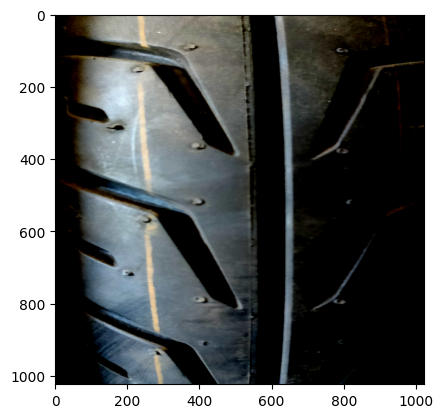

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


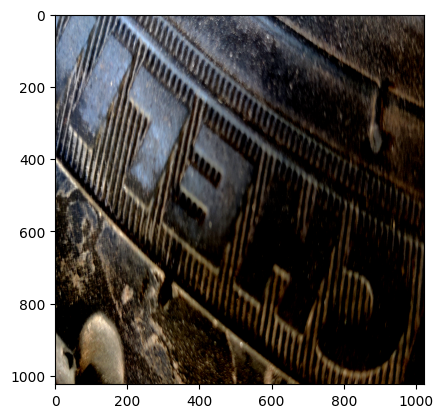

In [7]:
# Get two images and labels from the DataLoader
data_iterator = iter(dataloader)
images, labels = next(data_iterator)

# Function to display the images
def imshow(img):
    # img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display the first two images
imshow(images[0])
imshow(images[1])

In [8]:
total_size = len(tire_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

In [9]:
train_dataset, test_dataset = random_split(tire_dataset, [train_size, test_size])

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)